# 1 - Installations


Begin by uncommenting and running the cell below to install the dependencies needed for this challenge.

In [267]:
import stim
import pymatching
import sinter
from typing import List
import matplotlib.pyplot as plt
import os 
import numpy as np


print(stim.__version__)

1.15.0


In this section, we will benchmark the cat-repetition code against a conventional surface code built from unbiased qubits. While the surface code is designed to protect against general, symmetric noise, the cat-repetition code is optimized for a strongly biased error channel in which phase flips are exponentially suppressed and bit flips dominate. By comparing these two architectures under their respective noise models, we can directly evaluate the advantages of exploiting hardware bias. We will focus on resource efficiency, logical error rates, and scaling with system size to highlight when and why a bias-tailored code can outperform a more general-purpose quantum error correcting code.

Here is an especially useful resource for this section: 
[https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb)

Please feel free to adapt code from the above notebook. The point of the tasks in this section is to explore logical error rates and hardware resource overheads in different parameter regimes, not figure out syntax.

## Task 4.1 - cat-repetition code threshold

Since cat qubits can exponentially suppress phase-flip errors, the dominant remaining noise channel is bit flips on the encoded qubits. In this task, you will study how the logical error rate scales with the number of cat qubits used as data qubits in a repetition code, assuming each data qubit experiences a fixed bit-flip error rate.

[TODO, 2.5pts]: First, complete `generate_rep_code_bit_flips` to return a repetition-code memory circuit with distance `d`, `3d` rounds, and bit-flip noise applied as `X_ERROR(noise)` on the data qubits. You may use Stim’s built-in repetition-code memory generator rather than implementing the circuit from scratch.

In [289]:
def generate_rep_code_bit_flips(d, noise):
    # SOLUTION ===
    circuit = stim.Circuit.generated(
        "repetition_code:memory",
        rounds=3 * d,
        distance=d,
        before_measure_flip_probability=noise
    )
    # ===
    return circuit

We can then use this repetition code generation function to once again extract a threshold.

In [290]:
tasks = [
    sinter.Task(
        circuit=generate_rep_code_bit_flips(d, noise),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500,
)

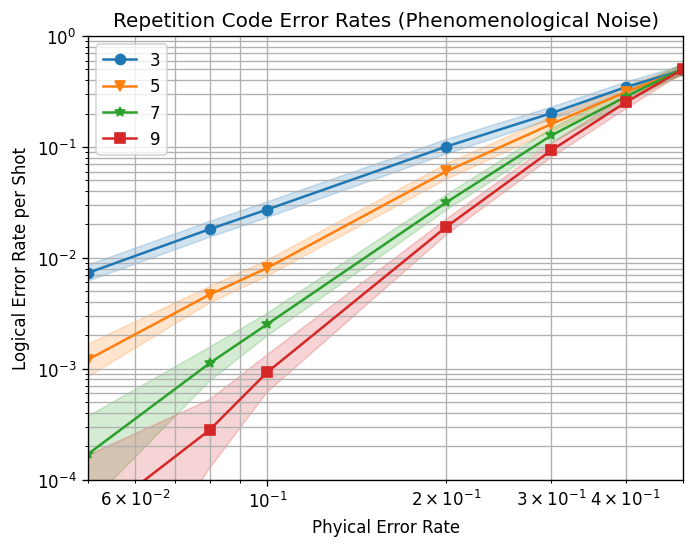

In [291]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-4, 1e-0)
ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

[TODO, 2.5pts]: Next, fix the physical bit-flip probability to $p_X = 0.01$. Assuming a cat-qubit noise bias of $10^8$, the corresponding phase-flip probability is $p_Z = 10^{-10}$. How many cat qubits are required in a repetition code to suppress the logical bit-flip probability below $10^{-10}$, so that it is comparable to the phase-flip level?

These parameter choices are loosely inspired by the following references, which provide a more detailed and rigorous analysis of error correction with cat qubits:
- [https://arxiv.org/abs/2302.06639](https://arxiv.org/abs/2302.06639)
- [https://arxiv.org/abs/2401.09541](https://arxiv.org/abs/2401.09541) 

Make a plot of logical error rate versus code distance $d$ for fixed $p_X = 0.01$. Note that the code distance $d$ is equal to the number of data qubits $n$ for the repetition code. Use `generate_rep_code_bit_flips`, which injects only bit flips, since phase flips are negligible in this regime.


In [ ]:
bit_flip_prob = 0.01
noise_bias = 1e8
goal_logical_error_rate = bit_flip_prob/noise_bias

distances = [3, 5, 7]
tasks = [
    sinter.Task(
        circuit=generate_rep_code_bit_flips(d, bit_flip_prob),
        json_metadata={'d': d},
    )
    for d in distances
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000_000, 
    max_errors=1000,      
)

xs = np.array([s.json_metadata['d'] for s in collected_stats])
ys = np.array([s.errors / s.shots for s in collected_stats])

valid = ys > 0
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xs[valid], np.log10(ys[valid]))

required_d_float = (np.log10(goal_logical_error_rate) - intercept) / slope
required_d = int(np.ceil(required_d_float))
if required_d % 2 == 0: required_d += 1

print(f"Predicted distance required: d = {required_d}")

plt.figure(figsize=(10, 6))
plt.semilogy(xs, ys, 'bo', markersize=8, label='Simulated Data')

plot_xs = np.linspace(min(xs), required_d + 2, 100)
plt.semilogy(plot_xs, 10**(slope * plot_xs + intercept), 'r--', alpha=0.7)

plt.axhline(goal_logical_error_rate, color='green', linestyle=':', label=f'Goal ({goal_logical_error_rate:.1e})')
plt.axvline(required_d, color='black', linestyle='-.', alpha=0.3, label=f'Required d={required_d}')

plt.xlabel('Code Distance (d)', fontsize=12)
plt.ylabel('Logical Error Rate', fontsize=12)
plt.title(f'Logical Bit-Flip Suppression (Physical $p_X = {bit_flip_prob}$)', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

## 4.2 - surface code benchmarks

The surface code can be viewed as a two-dimensional generalization of the repetition code that protects against both bit-flip and phase-flip errors. For this reason, many groups are pursuing surface-code architectures built from unbiased qubits (such as transmons) to suppress both types of logical errors simultaneously.

Next, we will generate an analogous plot of logical error rate versus the number of data qubits for a fixed physical depolarizing error probability of 0.001 using the surface code. From this, we will estimate how many qubits are required to reach a logical error rate of ($10^{-10}$), enabling a direct comparison with the cat-repetition results.


### 4.2.1 - surface code threshold

[TODO, 2.5pts]: First, complete `generate_surface_code_depolraizing_noise` to return a surface-code memory circuit with distance `d`, `3d` rounds, and depolarizing noise applied on data qubits. You may use Stim’s built-in surface-code memory generator and flags rather than implementing the circuit from scratch.

In [ ]:
def generate_surface_code_depolarizing_noise(d, noise):
    # SOLUTION ===
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=3 * d,
        distance=d,
        before_round_data_depolarization=noise,
        after_clifford_depolarization=noise
    )
    # ===
    return circuit

Then, we can use stim tooling to find the threshold for the surface code.

In [212]:
import os

surface_code_tasks = [
    sinter.Task(
        circuit = generate_surface_code_depolarizing_noise(d, noise),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [0.008, 0.009, 0.01, 0.011, 0.012]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=os.cpu_count(),
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 8 workers...
15 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching <1m     996655        4729 d=3,r=9,p=0.008 
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.009 
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.01  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.011 
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.012 
        1 pymatching   ?    1000000        5000 d=5,r=15,p=0.008
        1 pymatching   ?    1000000        5000 d=5,r=15,p=0.009
        1 pymatching   ?    1000000        5000 d=5,r=15,p=0.01 
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.011
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.012
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.008
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.009
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.01 
        0 pymatching ?·∞    1000000        5000 d=7,r

In [ ]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
ax.set_ylim(5e-3, 5e-2)
ax.set_xlim(0.008, 0.012)
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

### 4.2.2 - estimate # of qubits for fault-tolerance

[TODO, 2.0pts]: Next, fix the depolarizing noise probability to $p = 0.001$, inspired by SOTA performance in transmon-based surface codes. As we did for the cat-repetition code, make a plot of logical error rate versus code distance $d$, which is equal to $\sqrt{n}$ for the square surface code, where $n$ is the number of data qubits. Use your `generate_surface_code_depolarizing_noise` function. The lower ylim of your plot should be `goal_logical_error_rate`. 

Predicted distance for logical error < 10^-10: d ≈ 19


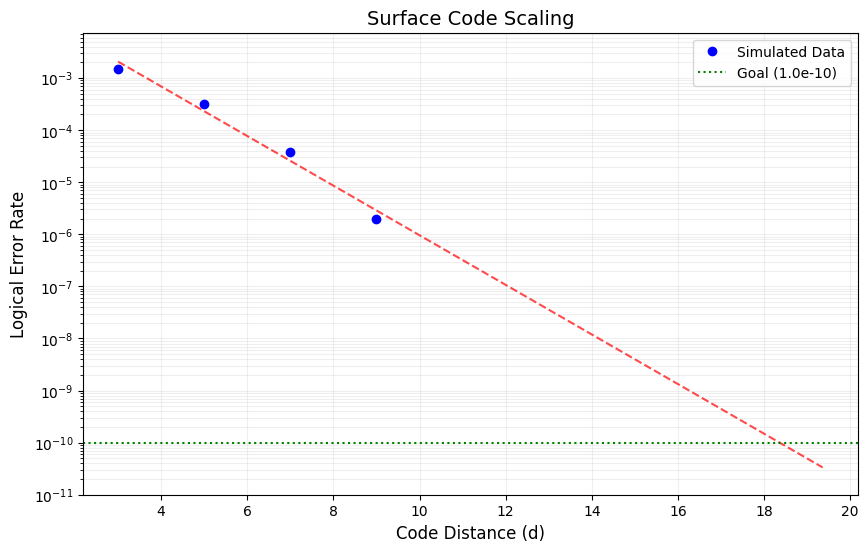

In [214]:
noise = 1e-3
goal_logical_error_rate = 1e-10

# SOLUTION ===
distances = [3, 5, 7, 9]

tasks = [
    sinter.Task(
        circuit=generate_surface_code_depolarizing_noise(d, noise),
        json_metadata={'d': d},
    )
    for d in distances
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=500,
)

xs = []
ys = []
for s in collected_stats:
    d = s.json_metadata['d']
    err_rate = s.errors / s.shots
    if err_rate > 0:
        xs.append(d)
        ys.append(err_rate)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xs, np.log10(ys))

plt.figure(figsize=(10, 6))
plt.semilogy(xs, ys, 'bo', label='Simulated Data')
required_d = (np.log10(goal_logical_error_rate) - intercept) / slope
plot_xs = np.linspace(min(distances), required_d + 1, 100)
plt.semilogy(plot_xs, 10**(slope * plot_xs + intercept), 'r--', alpha=0.7)

# Horizontal line for the goal
plt.axhline(goal_logical_error_rate, color='green', linestyle=':', label=f'Goal ({goal_logical_error_rate:.1e})')

# Set plot limits and labels
plt.ylim(bottom=goal_logical_error_rate / 10, top=max(ys) * 5)
plt.xlabel('Code Distance (d)', fontsize=12)
plt.ylabel('Logical Error Rate', fontsize=12)
plt.title(f'Surface Code Scaling', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

print(f"Predicted distance for logical error < 10^-10: d ≈ {int(np.ceil(required_d))}")
plt.show()

# ===

[TODO, 0.5pts]: Finally, compare the performance of the cat-repetition code to the surface code. In particular, comment on the resource requirements and potential challenges of both approaches.

# 5 - Quantum error correction inspired by classical codes

## Core Task 5.1 - Explore QEC codes inspired by classical codes

[TODO, 70pts]:

Classical error correcting codes provide a natural and powerful pathway to constructing quantum codes by directly translating classical parity checks into quantum stabilizer measurements. In particular, any linear classical code can be mapped to a quantum code that detects and corrects **bit flip (X) errors** by promoting each classical parity check into a multi-qubit ( Z )-type stabilizer. In this construction, classical codewords become logical quantum states, and the syndrome extraction process is identical in spirit to classical decoding. This approach is especially well suited for hardware with **strong noise bias**, where one error channel dominates. In our case, biased cat qubits exponentially suppress phase flip errors, leaving bit flips as the primary failure mode. As a result, we can focus entirely on X-error correction, allowing us to use a much wider and more efficient family of classical codes than would be possible for fully general quantum noise.

The final and core challenge is to choose any classical error correcting code (or family of codes), translate it into its quantum counterpart, and benchmark it against the repetition code that you already implemented. You will simulate the resulting quantum code in **Stim**, extract syndromes, perform decoding, and compare key performance metrics such as logical error rate versus number of physical qubits at a fixed physical error rate, encoding efficiency ( k/n ), the effective distance of the code and required hardware connectivity (i.e. what two-qubit gates are needed). This exploration will show how classical coding theory can be directly leveraged to design quantum codes that outperform simple repetition strategies when the noise is strongly biased.

*Optionally*, only if time permits, you may wish to demonstrate a universal, fault-tolerant set of logical gates for your code, starting with the Clifford group and extending to non-Clifford gates.


Please refer to `./2-classical-to-quantum-codes.ipynb` for a step-by-step introduction to translating a classical code into a quantum bit-flip–correcting code, along with a curated (but not exhaustive) list of classical code families to use as inspiration. You should consider this notebook required reading for the core task in this challenge.

This is an open-ended challenge, judged by the criteria specified in the `README.md` doc. 

In [215]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import comb

In [216]:
class BCH_Code:
    """
    Generic class for BCH cyclic codes.
    Parameters n, k, t, generator polynomial g_poly.
    """
    def __init__(self, n, k, t, g_poly):
        self.n = n
        self.k = k
        self.t = t

# Goal: try to implement a [[15, 7, 5]] code (that allows correction of 2 errors) using BCH codes, and benchmark its performance against cat-repetition codes of similar length
# We'll assume strong noise bias conditions, focusing on bit-flip (X) errors

# From math derivations, we know that a BCH [[15, 7, 5]] code is associated with the following generator polynomial g(x) and parity check polynomial h(x):
# g(x) = x^8 + x^7 + x^6 + x^4 + 1
# h(x) = (x^15 - 1) / g(x) = x^7 + x^6 + x^4 + 1
        
        # parity polynomial h(x) = (x^n - 1) / g(x)
        h_poly = self._poly_div_gf2(self.n, g_poly)
        
        # parity check matrix H
        self.num_checks = self.n - self.k
        self.H = np.zeros((self.num_checks, self.n), dtype=np.uint8)
        h_rev = np.flip(h_poly)
        for r in range(self.num_checks):
            self.H[r, r:r+len(h_rev)] = h_rev

# Each row of H corresponds to a stabilizer generator measuring the parity of a subset of qubits

# We are gonna start with the trivial state |0...0>
# To recover from bit-flip errors, the easiest way is to use a brute force lookup-table
        # syndrome table
        self.lookup = {}
        
        # 0 Errors
        self.lookup[self._key(np.zeros(self.num_checks, dtype=np.uint8))] = np.zeros(self.n, dtype=np.uint8)
        
        # 1 to t Errors
        for w in range(1, self.t + 1):
            for locs in combinations(range(self.n), w):
                e = np.zeros(self.n, dtype=np.uint8)
                e[list(locs)] = 1
                
                syn = (self.H @ e) % 2
                self.lookup[self._key(syn)] = e

    def theoretical_pL(self, p):
        """Calculates theoretical failure rate (errors > t)."""
        # Sum probabilities of k errors where k is from t+1 to n
        return sum(comb(self.n, k) * (p**k) * ((1-p)**(self.n-k)) 
                   for k in range(self.t + 1, self.n + 1))

    def _poly_div_gf2(self, n, divisor):
        """Computes (x^n + 1) / divisor in GF(2)."""
        dividend = np.zeros(n + 1, dtype=np.uint8)
        dividend[0] = 1; dividend[n] = 1
        quotient = np.zeros(n + 1, dtype=np.uint8)
        remainder = dividend.copy()
        deg_div = len(divisor) - 1
        
        while True:
            non_zeros = np.where(remainder)[0]
            if len(non_zeros) == 0: break
            deg_rem = non_zeros[-1]
            if deg_rem < deg_div: break
            
            diff = deg_rem - deg_div
            quotient[diff] = 1
            shifted_divisor = np.zeros(len(remainder), dtype=np.uint8)
            shifted_divisor[diff : diff + len(divisor)] = divisor
            remainder = (remainder + shifted_divisor) % 2
            
        last_nonzero = np.max(np.where(quotient)[0])
        return quotient[:last_nonzero+1]

    def _key(self, array):
        return array.tobytes()

In [256]:
def run_simulation(bch, probs):
    """
    Runs the simulation using the quantum circuit logic (Ancillas + CNOTs).
    """
    results = []
    theory = []
    
    print(f"{'p_phys':<10} | {'p_logical':<12} | {'theory':<12}")
    
    # INDICES SETUP
    n = bch.n
    m = bch.num_checks
    data_qubits = list(range(n))
    anc_qubits = list(range(n, n + m))

    for p in probs:
        circuit = stim.Circuit()

        circuit.append("R", data_qubits + anc_qubits)
        circuit.append("TICK")

        circuit.append("X_ERROR", data_qubits, p)
        circuit.append("TICK")
  
        for i, row in enumerate(bch.H):
            targets = []
            a = anc_qubits[i]
            for j, bit in enumerate(row):
                if bit:
                    targets += [j, a]
            
            if targets:
                circuit.append("CX", targets)
            circuit.append("TICK")
            
        circuit.append("M", anc_qubits)
        
        for i in range(m):
            circuit.append("DETECTOR", [stim.target_rec(-m + i)], [i, 0])

        circuit.append("M", data_qubits)
        
        shots = 10_000_000
        sampler = circuit.compile_sampler()
        samples = sampler.sample(shots=shots)
        
        fails = 0   
        for i in range(shots):
            full_readout = samples[i]

            syndrome_bits = full_readout[:m]
            noisy_data = full_readout[m:]
            
            syn_key = syndrome_bits.tobytes()
            
            if syn_key in bch.lookup:
                correction = bch.lookup[syn_key]
                final_state = (noisy_data + correction) % 2
                
                # Logic Failure Check
                if np.any(final_state):
                    fails += 1
            else:
                fails += 1
                
        p_sim = fails / shots
        p_th = bch.theoretical_pL(p)
        
        results.append(p_sim)
        theory.append(p_th)
        
        print(f"{p:<10.4f} | {p_sim:<12.6f} | {p_th:<12.6f}")

    return results, theory

p_phys     | p_logical    | theory      
0.0020     | 0.000004     | 0.000004    
0.0030     | 0.000013     | 0.000012    
0.0050     | 0.000052     | 0.000054    
0.0060     | 0.000097     | 0.000093    
0.0080     | 0.000218     | 0.000217    
0.0100     | 0.000418     | 0.000416    
0.0150     | 0.001318     | 0.001341    
0.0200     | 0.003008     | 0.003039    
0.0250     | 0.005639     | 0.005674    
0.0300     | 0.009398     | 0.009371    
0.0400     | 0.020319     | 0.020292    
0.0500     | 0.036148     | 0.036200    


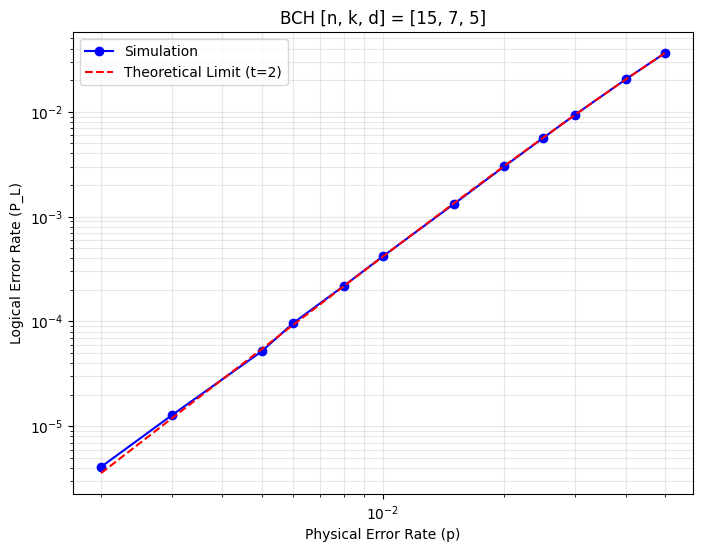

In [257]:
if __name__ == "__main__":
    N = 15
    K = 7
    T = 2
    
    # low to high
    G_POLY = np.array([1, 0, 0, 0, 1, 0, 1, 1, 1], dtype=np.uint8) 

    my_code = BCH_Code(n=N, k=K, t=T, g_poly=G_POLY)
    probabilities = [0.002, 0.003, 0.005, 0.006, 0.008, 0.01, 0.015,  0.02, 0.025, 0.03, 0.04, 0.05]
    sim_res, th_res = run_simulation(my_code, probabilities)
    
    # plot
    plt.figure(figsize=(8, 6))
    plt.loglog(probabilities, sim_res, 'o-', color='blue', label='Simulation')
    plt.loglog(probabilities, th_res, 'r--', label=f'Theoretical Limit (t={T})')
    plt.xlabel('Physical Error Rate (p)')
    plt.ylabel('Logical Error Rate (P_L)')
    plt.title(f'BCH [n, k, d] = [{N}, {K}, {2*T+1}]')
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

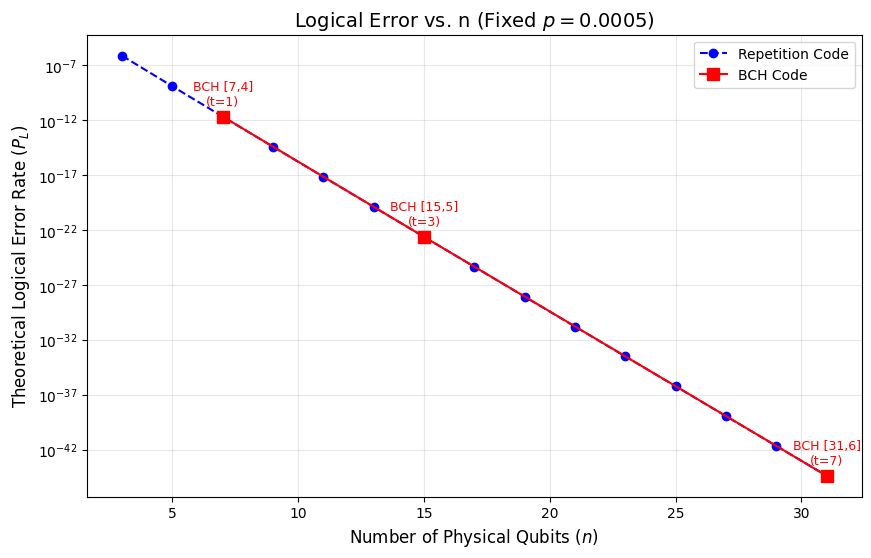

In [255]:
def theoretical_pL_bch(p, n, t):
    """
    minimum theoretical logical error rate for bch, where t is maximized
    """
    return sum(comb(n, k) * (p**k) * ((1-p)**(n-k)) 
               for k in range((n + 1) // 2, n + 1))

def theoretical_pL_rep(p, n):
    """
    theoretical logical error rate for repetition code
    """
    threshold = (n + 1) // 2
    return sum(comb(n, k) * (p**k) * ((1-p)**(n-k)) for k in range(threshold, n + 1))

FIXED_P = 0.0005  # 0.5% physical error rate

# repetition code
rep_ns = np.arange(3, 33, 2)
rep_y = [theoretical_pL_rep(FIXED_P, n) for n in rep_ns]

# BCH code
bch_configs = [
    (7, 1),   # BCH [7, 4, 3]  (t=1)
    (15, 3),  # BCH [15, 5, 7] (t=3)
    (31, 7)   # BCH [31, 6, 15] (t=7) 
]

bch_ns = [c[0] for c in bch_configs]
bch_y = [theoretical_pL_bch(FIXED_P, n, t) for n, t in bch_configs]

plt.figure(figsize=(10, 6))


plt.semilogy(rep_ns, rep_y, 'bo--', label='Repetition Code')
plt.semilogy(bch_ns, bch_y, 'rs-', markersize=8, label='BCH Code')

# Annotations
plt.text(7, bch_y[0] * 10, 'BCH [7,4]\n(t=1)', color='red', ha='center', fontsize=9)
plt.text(15, bch_y[1] * 10, 'BCH [15,5]\n(t=3)', color='red', ha='center', fontsize=9)
plt.text(31, bch_y[2] * 10, 'BCH [31,6]\n(t=7)', color='red', ha='center', fontsize=9)

plt.xlabel('Number of Physical Qubits ($n$)', fontsize=12)
plt.ylabel('Logical Error Rate ($P_L$)', fontsize=12)
plt.title(f'Logical Error vs. n (Fixed $p={FIXED_P}$)', fontsize=14)
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()

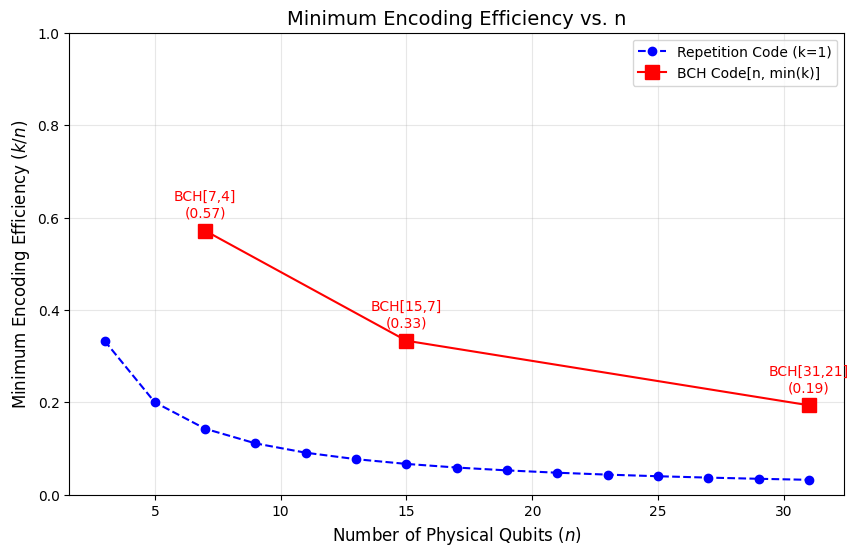

In [263]:
# Repetition Codes
rep_ns = np.arange(3, 33, 2)
rep_ks = np.ones_like(rep_ns)
rep_efficiency = rep_ks / rep_ns

# BCH Codes
bch_configs = [
    (7, 4),
    (15, 5),
    (31, 6)
]
bch_ns = [c[0] for c in bch_configs]
bch_efficiency = [c[1]/c[0] for c in bch_configs]


plt.figure(figsize=(10, 6))
plt.plot(rep_ns, rep_efficiency, 'bo--', label='Repetition Code (k=1)')

# BCH Points
plt.plot(bch_ns, bch_efficiency, 'rs-', markersize=10, label='BCH Code[n, min(k)]')

# Annotations for BCH
for n, eff, k in zip(bch_ns, bch_efficiency, [4, 7, 21]):
    plt.annotate(f'BCH[{n},{k}]\n({eff:.2f})', 
                 (n, eff), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 color='red')

plt.xlabel('Number of Physical Qubits ($n$)', fontsize=12)
plt.ylabel('Minimum Encoding Efficiency ($k/n$)', fontsize=12)
plt.title('Minimum Encoding Efficiency vs. n', fontsize=14)
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.ylim(0, 1.0)  # Efficiency is between 0 and 1
plt.show()

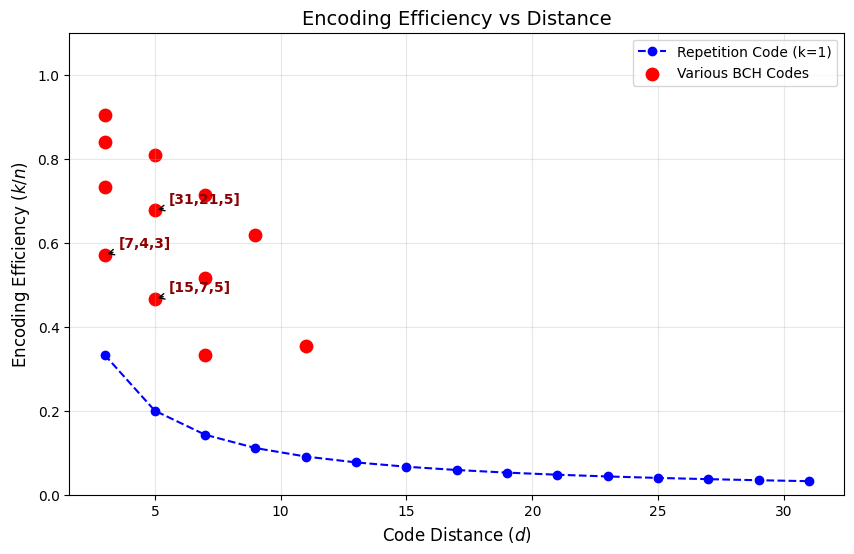

In [235]:
# 1. Repetition Codes
rep_d = np.arange(3, 32, 2)
rep_eff = 1 / rep_d

# 2. BCH Codes
bch_codes = [
    (7, 4, 3),
    (15, 11, 3), (15, 7, 5), (15, 5, 7),
    (31, 26, 3), (31, 21, 5), (31, 16, 7), (31, 11, 11),
    (63, 57, 3), (63, 51, 5), (63, 45, 7), (63, 39, 9)
]

bch_d = [c[2] for c in bch_codes]
bch_eff = [c[1]/c[0] for c in bch_codes]

# 3. Plotting
plt.figure(figsize=(10, 6))

# Repetition Line
plt.plot(rep_d, rep_eff, 'bo--', label='Repetition Code (k=1)')

# BCH Points
plt.scatter(bch_d, bch_eff, color='red', s=80, label='BCH Codes')

# Highlight the specific ones from our previous simulations
highlights = [(7,4,3), (15,7,5), (31,21,5)]
for (n, k, d) in highlights:
    plt.annotate(f'[{n},{k},{d}]', 
                 (d, k/n), 
                 xytext=(10, 5), 
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", color='black'),
                 color='darkred',
                 fontweight='bold')

plt.xlabel('Code Distance ($d$)', fontsize=12)
plt.ylabel('Encoding Efficiency ($k/n$)', fontsize=12)
plt.title('Encoding Efficiency vs Distance', fontsize=14)
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.ylim(0, 1.1)
plt.show()

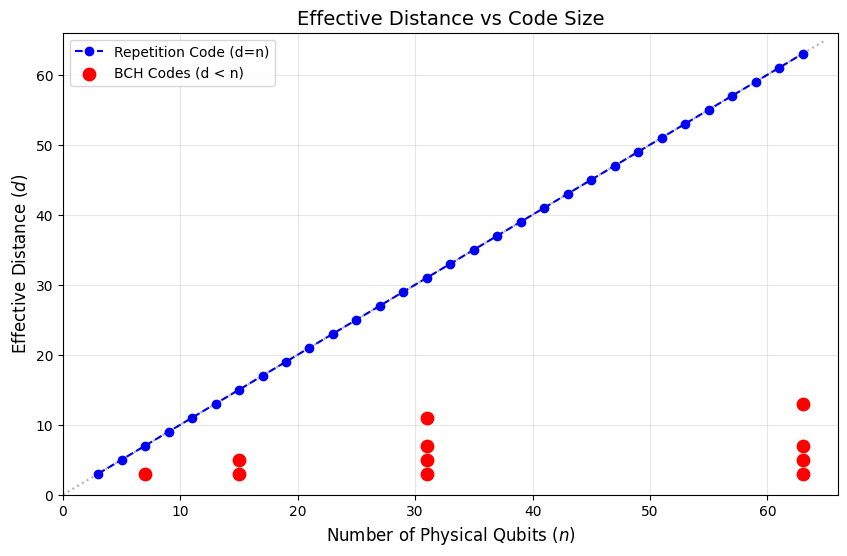

In [264]:
import matplotlib.pyplot as plt
import numpy as np

# Repetition Codes
rep_n = np.arange(3, 65, 2)
rep_d = rep_n  # d = n

# BCH Codes
bch_codes = [
    (7, 4, 3),
    (15, 11, 3),
    (15, 7, 5),
    (31, 26, 3),
    (31, 21, 5),
    (31, 16, 7),
    (31, 11, 11),
    (63, 57, 3),
    (63, 51, 5),
    (63, 45, 7),
    (63, 30, 13)
]

bch_n = [c[0] for c in bch_codes]
bch_d = [c[2] for c in bch_codes]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rep_n, rep_d, 'bo--', label='Repetition Code (d=n)')

# BCH Points
plt.scatter(bch_n, bch_d, color='red', s=80, label='BCH Codes (d < n)', zorder=5)

plt.xlabel('Number of Physical Qubits ($n$)', fontsize=12)
plt.ylabel('Effective Distance ($d$)', fontsize=12)
plt.title('Effective Distance vs Code Size', fontsize=14)
plt.grid(True, which="both", alpha=0.3)
plt.legend()

plt.plot([0, 65], [0, 65], 'k:', alpha=0.3)

plt.xlim(0, 66)
plt.ylim(0, 66)
plt.show()